In [177]:
import simglucose
import gymnasium as gym
from collections import namedtuple, deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [178]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done', 'episode'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [179]:

from gymnasium.wrappers import FlattenObservation


def paper_reward_function(BG_last_hour):
    G = BG_last_hour[-1]
    if G >= 70 and G <= 180:
        return 0.5
    if G > 180 and G <= 200:
        return -0.9
    if G > 200 and G <= 250:
        return -1.2
    if G > 250 and G <= 350:
        return -1.5
    if G > 30 and G < 70:
        return -1.8
    else:
        return -2

gym.envs.register(
    id="simglucose-bolus",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": ["adult#001"],
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)




c:\Users\Mena Lerf\anaconda3\envs\rl_sim\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment simglucose-bolus already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [180]:

def create_env():

    env = gym.make("simglucose-bolus")

    env = FlattenObservation(env)

    return env



env = create_env()


print(env.action_space)
print(env.observation_space)

# random action
env.reset()
for _ in range(100):
    env.step(env.action_space.sample())  # take a random action
#observation [GCM, CHO, Insulin]

Discrete(7)
Box(0.0, 10000.0, (3,), float32)


In [181]:
# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        # Define your neural network architecture
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

##### select_action funtion

1. The chosen action $a_t$ represents a percentage modulation $alpha_t$ of the mealtime insulin dose suggested by the standard therapy.
2. The modulation factor $alpha_t$) is randomly chosen from a set of possible percentage modulations.
3. The insulin amount suggested by the DDQN algorithm at time step $t$ is calculated using the formula: $BC_{ddqn}(t) = BC_s(t) + \alpha_t \cdot BC_s(t)$.

In [182]:
# Define the DDQ Agent
class DQNAgent:
    def __init__(self, input_size, output_size, gamma=0.99, learning_rate=0.001):
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Q-networks
        self.q_network = QNetwork(input_size, output_size).to(self.device)
        self.target_q_network = QNetwork(input_size, output_size).to(self.device)
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

    def select_action(self, state):
        print(state)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.q_network(state_tensor)
        action_index = q_values.argmax(1).item()
        # Possible percentage modulations of the insulin dose
        modulation_percentages = [25, 20, 10, 0, -10, -20, -25]
        # now selecting the alpha percentage as a random choice from the modulation percentages
        alpha_percentage = np.random.choice(modulation_percentages)
        alpha_factor = 1 + (alpha_percentage / 100.0)  # Convert percentage to a factor

        # Apply the modulation to the insulin dose suggested by standard therapy (BCs)
        action_value = alpha_factor * action_index

        return int(action_value) #TODO: action should not be a float, has to be dicrete. how to do that?

    def update_q_network(self, state, action, reward, next_state, done):
        state_tensor = torch.FloatTensor(state).to(self.device)
        next_state_tensor = torch.FloatTensor(next_state).to(self.device)
        action_tensor = torch.FloatTensor([action]).to(self.device)
        reward_tensor = torch.FloatTensor([reward]).to(self.device)

        # Q-value prediction for all actions
        q_values = self.q_network(state_tensor)
        
        # Action_tensor and q_values shapes must match
        action_tensor = action_tensor.expand_as(q_values)

        # Q-value for the selected action
        selected_q_value = torch.sum(q_values * action_tensor, dim=0, keepdim=True)

        with torch.no_grad():
            # Double Q-learning: Use the target network for action selection
            next_q_values = self.target_q_network(next_state_tensor)
            next_action_index = next_q_values.argmax(0, keepdim=True)
            target_q_values = reward_tensor + self.gamma * next_q_values.gather(0, next_action_index) * (1 - done)

        # Q-network loss
        loss = nn.functional.mse_loss(selected_q_value, target_q_values)

        # Backpropagation and optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_q_network(self):
        # Update the target Q-network by copying the parameters from the current Q-network
        self.target_q_network.load_state_dict(self.q_network.state_dict())

In [183]:
# Simglucose environment setup
patient_name = "adolescent#010"
env = create_env()

# DDQ Agent setup
 
state_size = env.observation_space.shape[0]  # Size of the state vector
action_size = env.action_space.n  # Size of the action space
print("State size: {}, Action size: {}".format(state_size, action_size))
agent = DQNAgent(input_size=state_size, output_size=action_size)

State size: 3, Action size: 7


In [184]:
state, info = env.reset()
print(state)
print(info)
action = agent.select_action(state)
print(action)
env.step(action)

[139.17044   0.        0.     ]
{'time': datetime.datetime(2018, 1, 1, 23, 0), 'meal': 0, 'patient_name': 'adult#001', 'sample_time': 3.0}
[139.17044   0.        0.     ]
4


(array([1.3897020e+02, 0.0000000e+00, 2.1122675e-02], dtype=float32),
 0.5,
 False,
 False,
 {'time': datetime.datetime(2018, 1, 1, 23, 3),
  'meal': 0,
  'patient_name': 'adult#001',
  'sample_time': 3.0})

In [185]:
#memory = ReplayBuffer(self.state_dimension, self.action_dimension)

In [186]:
# save rewards and gcms
rewards = []
gcms = []

# Training loop
num_episodes = 100
TARGET_UPDATE_FREQUENCY = 10
for episode in range(num_episodes):
    state, info = env.reset()
    total_reward = 0
    first_iteration = True

    while True:
        action = agent.select_action(state)

        # Step through the environment
        next_state, reward, done, _, info = env.step(action)

        # Update Q-network
        agent.update_q_network(state, action, reward, next_state, done)

        # Update target Q-network periodically
        if episode % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_q_network()

        state = next_state
        total_reward += reward

        if done:
            break
    rewards.append(total_reward)
    gcms.append(next_state[0])
    # observation [GCM, CHO, Insulin]
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}, GCM: {next_state[0]}")

[152.58385   0.        0.     ]
[1.5432428e+02 0.0000000e+00 2.1122675e-02]


[1.5930278e+02 0.0000000e+00 2.1122675e-02]
[1.6351994e+02 0.0000000e+00 2.1122675e-02]
[1.6689592e+02 0.0000000e+00 2.1122675e-02]
[1.6939981e+02 0.0000000e+00 2.1122675e-02]
[1.7102988e+02 0.0000000e+00 2.1122675e-02]
[1.7180141e+02 0.0000000e+00 2.1122675e-02]
[1.7173924e+02 0.0000000e+00 2.1122675e-02]
[1.7088388e+02 0.0000000e+00 2.1122675e-02]
[1.6934206e+02 0.0000000e+00 2.1122675e-02]
[1.6731706e+02 0.0000000e+00 2.1122675e-02]
[1.6503348e+02 0.0000000e+00 2.1122675e-02]
[1.6271553e+02 0.0000000e+00 2.1122675e-02]
[1.6056996e+02 0.0000000e+00 2.1122675e-02]
[1.5870103e+02 0.0000000e+00 2.1122675e-02]
[1.5705974e+02 0.0000000e+00 2.1122675e-02]
[1.5556256e+02 0.0000000e+00 2.1122675e-02]
[1.5412550e+02 0.0000000e+00 2.1122675e-02]
[1.5267221e+02 0.0000000e+00 2.1122675e-02]
[1.5117390e+02 0.0000000e+00 2.1122675e-02]
[1.4967352e+02 0.0000000e+00 2.1122675e-02]
[1.4822974e+02 0.0000000e+00 2.1122675e-02]
[1.4690105e+02 0.0000000e+00 2.1122675e-02]
[1.4575389e+02 0.0000000e+00 2.1

KeyboardInterrupt: 

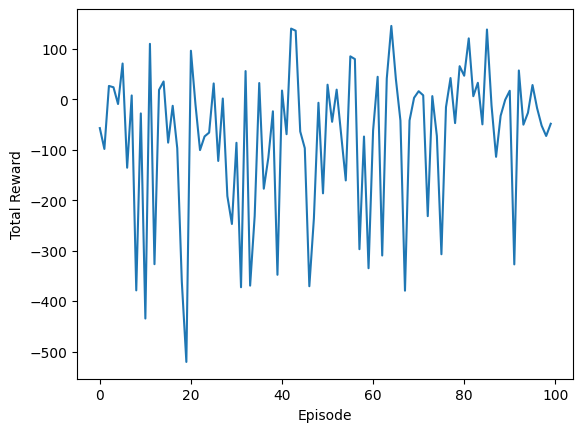

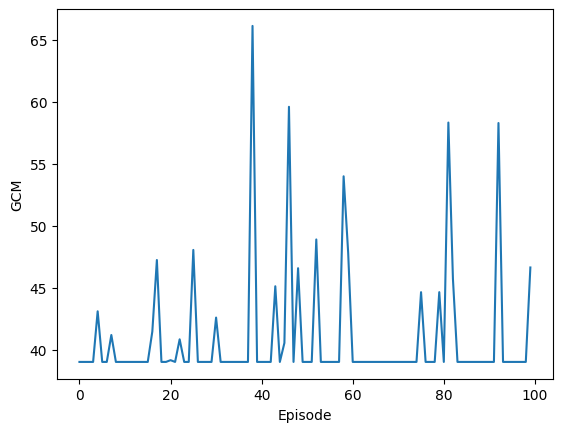

In [ ]:
#visualize the results
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

plt.plot(gcms)
plt.xlabel('Episode')
plt.ylabel('GCM')
plt.show()



### Train the network?

In [187]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque

In [188]:
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        # Define your neural network architecture
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

In [189]:
class DQNAgent:
    def __init__(
        self,
        input_size,
        output_size,
        gamma=0.99,
        learning_rate=0.001,
        buffer_size=10000,
        batch_size=32,
    ):
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Q-networks
        self.q_network = QNetwork(input_size, output_size).to(self.device)
        self.target_q_network = QNetwork(input_size, output_size).to(self.device)
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # Optimizer
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Experience replay buffer
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=buffer_size)

    def select_action(self, state):
        alpha_index = env.action_space.sample()
        return alpha_index

    def store_transition(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        self.replay_buffer.append(transition)

    def sample_batch(self):
        batch = random.sample(
            self.replay_buffer, min(len(self.replay_buffer), self.batch_size)
        )
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and handle dimensions
        states = torch.stack([torch.FloatTensor(state) for state in states])
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.stack(
            [torch.FloatTensor(next_state) for next_state in next_states]
        )
        dones = torch.FloatTensor(dones).unsqueeze(1)

        return states, actions, rewards, next_states, dones

    def update_q_network(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.sample_batch()
        # put all to device
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        # Compute Q-values
        q_values = self.q_network(states).gather(1, actions)

        # Compute target Q-values using the target network
        target_q_values = (
            rewards
            + (1 - dones)
            * self.gamma
            * self.target_q_network(next_states).max(1)[0].detach().unsqueeze(1)
        )
     
        # Compute the Huber loss
        loss = F.smooth_l1_loss(q_values, target_q_values)

        # Update the Q-network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_q_network(self):
        # Update the target network by copying the Q-network parameters
        self.target_q_network.load_state_dict(self.q_network.state_dict())

    def train_step(self, state, action, reward, next_state, done):
        # Store the transition in the replay buffer
        self.store_transition(state, action, reward, next_state, done)

        # Update the Q-network
        self.update_q_network()

        # Update the target Q-network periodically
        if len(self.replay_buffer) % 100 == 0:
            self.update_target_q_network()

In [190]:
def paper_reward_function(BG_last_hour):
    G = BG_last_hour[-1]
    if G >= 70 and G <= 180:
        return 0.5
    if G > 180 and G <= 200:
        return -0.9
    if G > 200 and G <= 250:
        return -1.2
    if G > 250 and G <= 350:
        return -1.5
    if G > 30 and G < 70:
        return -1.8
    else:
        return -2

gym.envs.register(
    id="simglucose-basal",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": ["adult#001"],
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)

def create_env():

    env = gym.make("simglucose-basal")

    env = FlattenObservation(env)

    return env



env = create_env()

c:\Users\Mena Lerf\anaconda3\envs\rl_sim\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment simglucose-basal already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [191]:
# DDQ Agent setup
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('state_size', state_size)
print('action_size', action_size)
agent = DQNAgent(input_size=state_size, output_size=action_size)

state_size 3
action_size 7


In [192]:
memory = ReplayMemory(10000)

In [204]:
num_episodes = 100

for episode in range(num_episodes):
    state, info = env.reset()
    total_reward = 0

    while True:
        action = agent.select_action(state)

        # Take the selected action in the environment
        next_state, reward, done, _, info = env.step(action)

        # Store the transition and perform a training step
        # PROBLEM WITH TORCH TENSOR CONVERSIONS

        agent.train_step(state, action, reward, next_state, done)
        state = next_state

        memory.push(state, action, next_state, reward, done, episode + 1)
       
        # Accumulate the total reward
        total_reward += reward

        if done:
            break  # End the episode if the environment signals that it's done

    print(f"Episode {episode + 1}, Total Reward: {total_reward}, GCM: {next_state[0]}")

C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be 

Episode 1, Total Reward: 67.9999999999999, GCM: 39.11294937133789


C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be 

Episode 2, Total Reward: 29.20000000000008, GCM: 39.0


C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be 

Episode 3, Total Reward: -65.79999999999988, GCM: 57.827491760253906


C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be 

Episode 4, Total Reward: -40.099999999999945, GCM: 43.47359848022461


C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)
C:\Users\Mena Lerf\AppData\Local\Temp\ipykernel_1960\153755405.py:48: DeprecationWarning: In future, it will be 

In [ ]:
state
#observation [GCM, CHO, Insulin]

array([3.9000000e+01, 0.0000000e+00, 2.1122675e-02], dtype=float32)

In [ ]:
state[0]

39.0

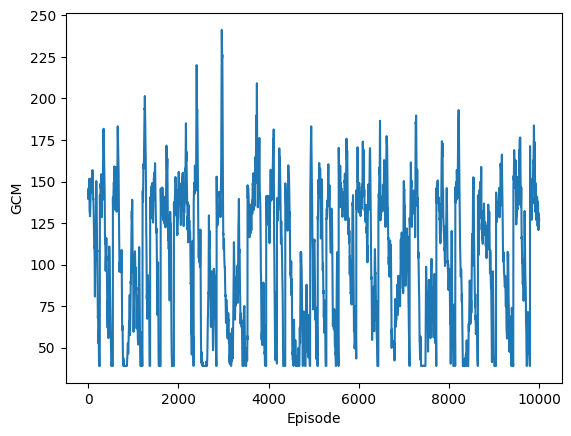

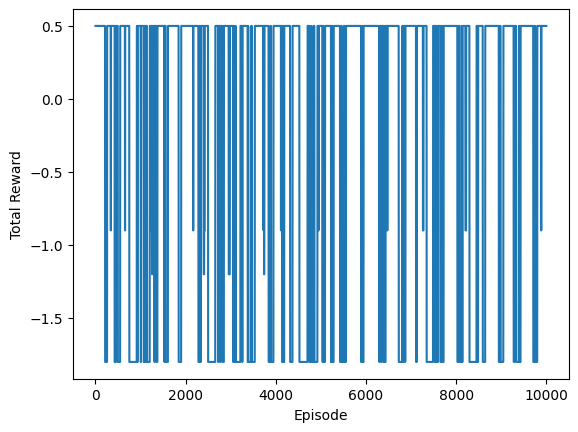

In [ ]:
# visualize results from the memory
import matplotlib.pyplot as plt

gcm_values = [transition.state[0] for transition in memory.memory]

plt.plot(gcm_values)
plt.xlabel("Episode")
plt.ylabel("GCM")
plt.show()

rewards = [transition.reward for transition in memory.memory]

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()
#'state', 'action', 'next_state', 'reward', 'done', 'episode'